In [4]:
import tensorflow as tf
import numpy as np

# Load the TensorFlow Lite model
model_path = "./model/pruned_quantized_model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)

# Allocate tensors (this is required before inference)
interpreter.allocate_tensors()

# Print model input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)


# Prepare input data (ensure it matches the input shape and data type)
input_shape = input_details[0]['shape']

for i in range(10):
    start_i = 0.25 * i
    test_thing = [round(start_i + (j * 0.1), 3) for j in range(0, 48)]
    
    print(f"Test Thing {i}:", test_thing)

    # Reshape test_thing to match the input shape
    test_thing = np.array(test_thing, dtype=np.float32).reshape(input_shape)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], test_thing)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("Output Data:", output_data)

Input Details: [{'name': 'serving_default_keras_tensor_8:0', 'index': 0, 'shape': array([ 1, 48,  1], dtype=int32), 'shape_signature': array([-1, 48,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 27, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Test Thing 0: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4,

In [2]:
import pandas as pd

data = pd.read_csv('./data/synthetic_data_independent_failures_4.csv')
print(data.head())

   machine_id            timestamp  T_internal_sensor   V_sensor  \
0           1  2025-01-01 00:00:00          39.836093  15.216207   
1           1  2025-01-01 01:00:00          41.391170  15.362536   
2           1  2025-01-01 02:00:00          44.109753  15.265230   
3           1  2025-01-01 03:00:00          44.786300  14.999927   
4           1  2025-01-01 04:00:00          44.876127  15.904049   

   failure_mode  is_precursor_period  is_final_failure  
0             1                    0                 0  
1             1                    0                 0  
2             1                    0                 0  
3             1                    0                 0  
4             1                    0                 0  


/tmp/ipykernel_109072/1298889356.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_data['timestamp'] = pd.to_datetime(machine_data['timestamp'])


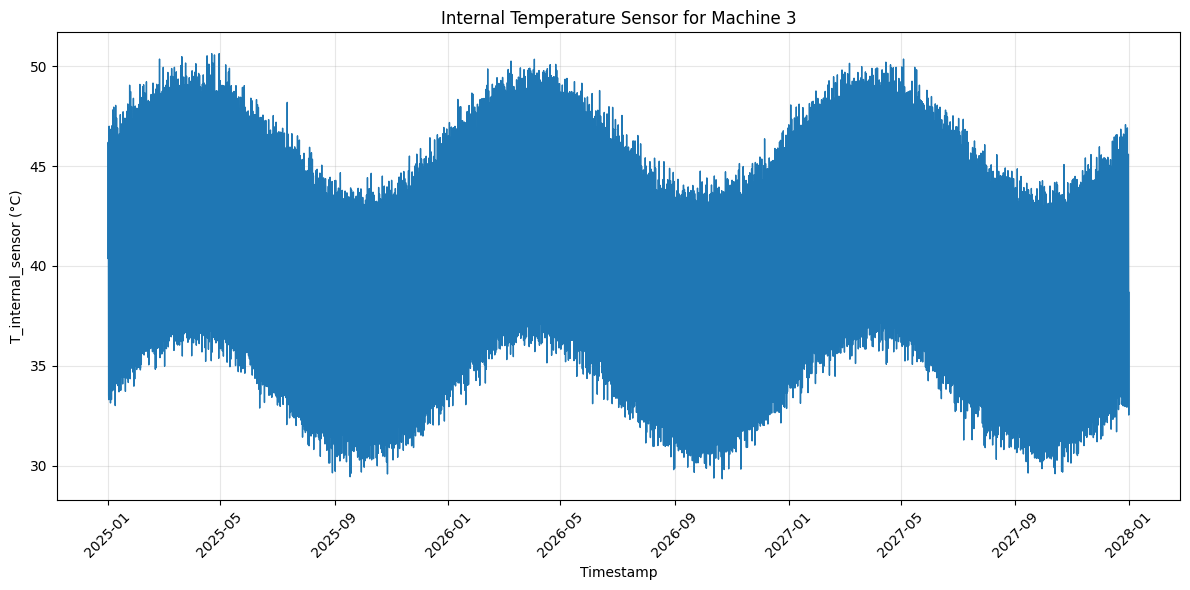

In [3]:
import matplotlib.pyplot as plt

# Select a single machine_id
machine_id = 3
machine_data = data[data['machine_id'] == machine_id]

# Convert timestamp to datetime
machine_data['timestamp'] = pd.to_datetime(machine_data['timestamp'])

# Sort by timestamp
machine_data = machine_data.sort_values('timestamp')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(machine_data['timestamp'], machine_data['T_internal_sensor'], linewidth=1)
plt.xlabel('Timestamp')
plt.ylabel('T_internal_sensor (°C)')
plt.title(f'Internal Temperature Sensor for Machine {machine_id}')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
import onnxruntime as ort

# Load the ONNX model
onnx_model_path = "./model/pruned_quantized_model.onnx"
session = ort.InferenceSession(onnx_model_path)

# Get model input/output details
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
input_shape = session.get_inputs()[0].shape

print(f"Input name: {input_name}")
print(f"Input shape: {input_shape}")
print(f"Output name: {output_name}")
print(f"Output shape: {session.get_outputs()[0].shape}")

Input name: input
Input shape: ['unk__227', 48, 1]
Output name: output
Output shape: ['unk__228', 1]


In [5]:
import numpy as np

# Scaling parameters
mean = 40.00946858359476
std = 4.8101438894455

# Prepare data for machine 1
machine_1_data = data[data['machine_id'] == 2].sort_values('timestamp').reset_index(drop=True)

# Extract features (T_internal_sensor and V_sensor)
features = machine_1_data[['T_internal_sensor', 'V_sensor']].values

# Create sequences of 48 time steps
sequence_length = 48
sequences = []
targets = []
indices = []

for i in range(len(features) - sequence_length):
    # Use only T_internal_sensor for input and scale it
    seq = features[i:i+sequence_length, 0]
    seq_scaled = (seq - mean) / std
    seq_scaled = seq_scaled.reshape(48, 1)  # Shape: (48, 1)
    sequences.append(seq_scaled)
    targets.append(machine_1_data['is_final_failure'].iloc[i+sequence_length])
    indices.append(i+sequence_length)

sequences = np.array(sequences, dtype=np.float32)
targets = np.array(targets)

print(f"Created {len(sequences)} sequences")
print(f"Sequence shape: {sequences.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Scaled data range: [{sequences.min():.4f}, {sequences.max():.4f}]")

Created 26232 sequences
Sequence shape: (26232, 48, 1)
Targets shape: (26232,)
Scaled data range: [-2.3295, 5.0407]


In [6]:
# Run predictions on all sequences
predictions = []

# Process in batches to avoid memory issues
batch_size = 1000
for i in range(0, len(sequences), batch_size):
    batch = sequences[i:i+batch_size]
    batch_predictions = session.run([output_name], {input_name: batch})[0]
    predictions.extend(batch_predictions)

predictions = np.array(predictions).flatten()

print(f"Generated {len(predictions)} predictions")
print(f"Prediction range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print(f"Mean prediction: {predictions.mean():.4f}")
print(f"Number of actual failures: {targets.sum()}")

Generated 26232 predictions
Prediction range: [-0.4410, 1.6181]
Mean prediction: 0.0188
Number of actual failures: 48


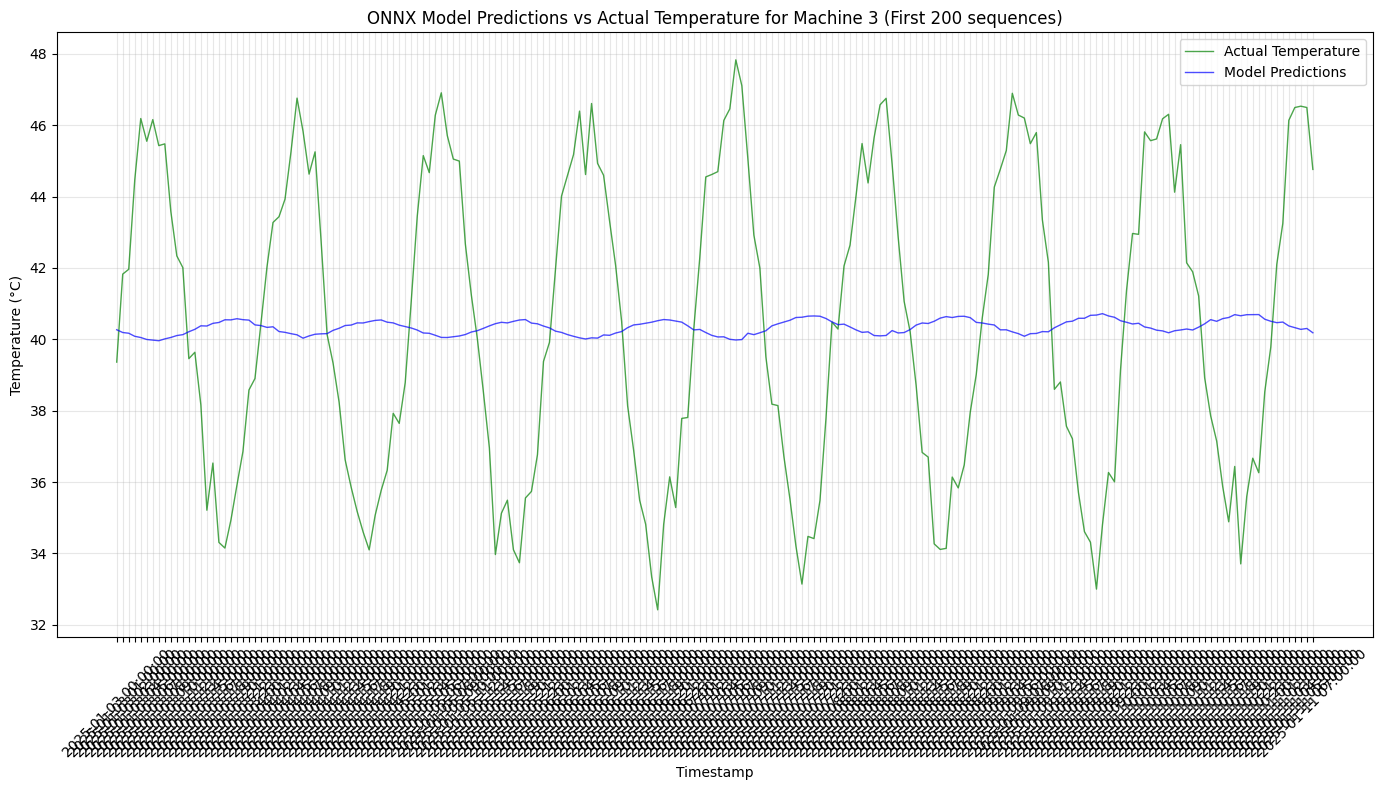


Showing first 200 sequences
Actual temperature range: [32.42°C, 47.83°C]
Predicted temperature range: [39.96°C, 40.72°C]
Mean actual temperature: 40.44°C
Mean predicted temperature: 40.34°C
Failures in this subset: 0

Unscaled MAE for Machine 3: 4.0455°C

Prediction Error Distribution:
Predictions within 5°C: 16703 (63.67%)
Predictions above 5°C off: 9529 (36.33%)
Total predictions: 26232


In [7]:
# Plot predictions over time (first 200 sequences only)
num_sequences_to_plot = 200
timestamps_subset = machine_1_data['timestamp'].iloc[indices[:num_sequences_to_plot]].values

# Rescale predictions back to original scale
predictions_rescaled = (predictions[:num_sequences_to_plot] * std) + mean
targets_subset = targets[:num_sequences_to_plot]

# Get actual temperature values
actual_temps = machine_1_data['T_internal_sensor'].iloc[indices[:num_sequences_to_plot]].values

fig, ax = plt.subplots(figsize=(14, 8))

# Plot actual and predicted temperatures
ax.plot(timestamps_subset, actual_temps, linewidth=1, alpha=0.7, label='Actual Temperature', color='green')
ax.plot(timestamps_subset, predictions_rescaled, linewidth=1, alpha=0.7, label='Model Predictions', color='blue')

# Highlight failure points
failure_indices = targets_subset == 1
if failure_indices.any():
    ax.scatter(timestamps_subset[failure_indices], actual_temps[failure_indices], 
               color='red', s=100, alpha=0.7, label='Actual Failures', zorder=5, marker='x')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Temperature (°C)')
ax.set_title(f'ONNX Model Predictions vs Actual Temperature for Machine {machine_id} (First {num_sequences_to_plot} sequences)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nShowing first {num_sequences_to_plot} sequences")
print(f"Actual temperature range: [{actual_temps.min():.2f}°C, {actual_temps.max():.2f}°C]")
print(f"Predicted temperature range: [{predictions_rescaled.min():.2f}°C, {predictions_rescaled.max():.2f}°C]")
print(f"Mean actual temperature: {actual_temps.mean():.2f}°C")
print(f"Mean predicted temperature: {predictions_rescaled.mean():.2f}°C")
print(f"Failures in this subset: {targets_subset.sum()}")

# Calculate unscaled MAE for the machine
from sklearn.metrics import mean_absolute_error
all_predictions_rescaled = (predictions * std) + mean
all_actual_temps = machine_1_data['T_internal_sensor'].iloc[indices].values
unscaled_mae = mean_absolute_error(all_actual_temps, all_predictions_rescaled)
print(f"\nUnscaled MAE for Machine {machine_id}: {unscaled_mae:.4f}°C")

# Count predictions within/outside 5°C threshold
absolute_errors = np.abs(all_actual_temps - all_predictions_rescaled)
within_5_degrees = np.sum(absolute_errors <= 5.0)
above_5_degrees = np.sum(absolute_errors > 5.0)
total_predictions = len(absolute_errors)

print(f"\nPrediction Error Distribution:")
print(f"Predictions within 5°C: {within_5_degrees} ({within_5_degrees/total_predictions*100:.2f}%)")
print(f"Predictions above 5°C off: {above_5_degrees} ({above_5_degrees/total_predictions*100:.2f}%)")
print(f"Total predictions: {total_predictions}")


In [8]:
import numpy as np

# Load the preprocessed test data
X_test = np.load('./data/finalized/X_test_feature_0.npy')
Y_test = np.load('./data/finalized/Y_test_feature_0.npy')

print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"X_test data range: [{X_test.min():.4f}, {X_test.max():.4f}]")
print(f"Y_test data range: [{Y_test.min():.4f}, {Y_test.max():.4f}]")

X_test shape: (3942, 48, 1)
Y_test shape: (3942,)
X_test data range: [-2.2669, 2.2984]
Y_test data range: [-1.0437, 1.1338]


In [9]:
# Run predictions on test data
predictions = []

# Process in batches to avoid memory issues
batch_size = 1000
for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i+batch_size].astype(np.float32)  # Ensure float32 type
    batch_predictions = session.run([output_name], {input_name: batch})[0]
    predictions.extend(batch_predictions)

predictions = np.array(predictions).flatten()

print(f"Generated {len(predictions)} predictions")
print(f"Prediction range (scaled): [{predictions.min():.4f}, {predictions.max():.4f}]")
print(f"Mean prediction (scaled): {predictions.mean():.4f}")
print(f"Actual range (scaled): [{Y_test.min():.4f}, {Y_test.max():.4f}]")
print(f"Mean actual (scaled): {Y_test.mean():.4f}")

Generated 3942 predictions
Prediction range (scaled): [-0.4536, 0.4230]
Mean prediction (scaled): -0.0135
Actual range (scaled): [-1.0437, 1.1338]
Mean actual (scaled): -0.0347


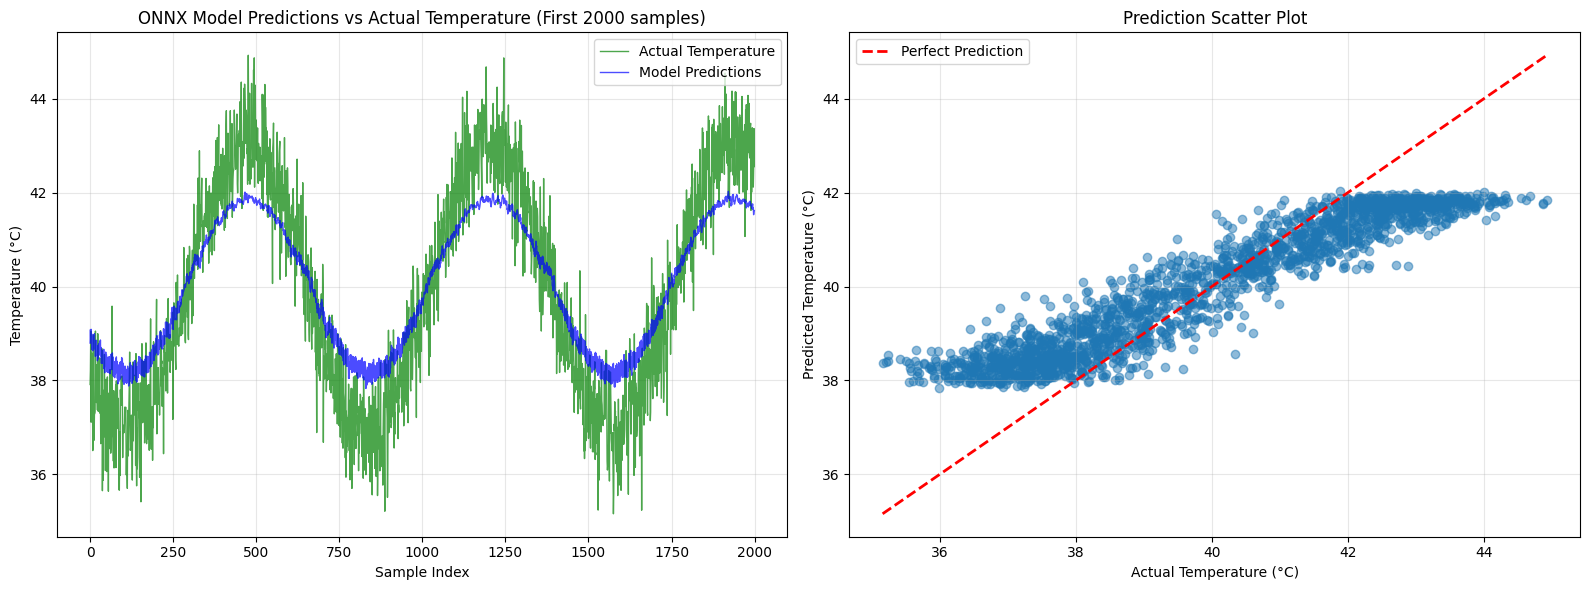


Showing first 2000 samples
Actual temperature range: [35.16°C, 44.93°C]
Predicted temperature range: [37.83°C, 42.03°C]
Mean actual temperature: 39.94°C
Mean predicted temperature: 40.01°C

Model Performance Metrics:
MSE: 1.2499
RMSE: 1.1180
MAE: 0.9197
R²: 0.7677


In [10]:
import matplotlib.pyplot as plt

# Scaling parameters (same as training)
mean = 40.00946858359476
std = 4.8101438894455

# Plot predictions over time (first 2000 sequences)
num_sequences_to_plot = min(2000, len(predictions))

# Rescale predictions back to original scale
predictions_rescaled = (predictions[:num_sequences_to_plot] * std) + mean
actual_rescaled = (Y_test[:num_sequences_to_plot].flatten() * std) + mean

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time series
axes[0].plot(range(num_sequences_to_plot), actual_rescaled, linewidth=1, alpha=0.7, label='Actual Temperature', color='green')
axes[0].plot(range(num_sequences_to_plot), predictions_rescaled, linewidth=1, alpha=0.7, label='Model Predictions', color='blue')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title(f'ONNX Model Predictions vs Actual Temperature (First {num_sequences_to_plot} samples)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Scatter plot
axes[1].scatter(actual_rescaled, predictions_rescaled, alpha=0.5)
mn = min(actual_rescaled.min(), predictions_rescaled.min())
mx = max(actual_rescaled.max(), predictions_rescaled.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Temperature (°C)')
axes[1].set_ylabel('Predicted Temperature (°C)')
axes[1].set_title('Prediction Scatter Plot')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nShowing first {num_sequences_to_plot} samples")
print(f"Actual temperature range: [{actual_rescaled.min():.2f}°C, {actual_rescaled.max():.2f}°C]")
print(f"Predicted temperature range: [{predictions_rescaled.min():.2f}°C, {predictions_rescaled.max():.2f}°C]")
print(f"Mean actual temperature: {actual_rescaled.mean():.2f}°C")
print(f"Mean predicted temperature: {predictions_rescaled.mean():.2f}°C")

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(actual_rescaled, predictions_rescaled)
mae = mean_absolute_error(actual_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(actual_rescaled, predictions_rescaled)

print(f"\nModel Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")